In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
import re
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

In [2]:
#REf:https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras

In [3]:
from transformers import DistilBertTokenizer, TFDistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('../input/tfdistilbertbaseuncased')

In [4]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

# removing unused columns
train_data.drop(['url_legal', 'license','standard_error'], axis=1, inplace=True)
test_data.drop(['url_legal', 'license'], axis=1, inplace=True)

#for i in range(len(train_data)):
#  train_data['excerpt'][i]=re.sub('[^A-Za-z0-9]+', ' ', train_data['excerpt'][i]).strip()
#for i in range(len(test_data)):
#  test_data['excerpt'][i]=re.sub('[^A-Za-z0-9]+', ' ', test_data['excerpt'][i]).strip()

from sklearn.model_selection import train_test_split
X=train_data['excerpt']
y=train_data['target']
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=20)
#x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.15,random_state=20)
x_td=test_data['excerpt']
#X_td_tokens,X_td_mask,X_td_segment=tokenize(x_td)
#X_td_pooled_output=bert_model.predict([X_td_tokens, X_td_mask, X_td_segment])

In [5]:
MAX_LENGTH = 150

In [6]:
def batch_encode(tokenizer, texts, batch_size=256, max_length=MAX_LENGTH):
    input_ids = []
    attention_mask = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,max_length=max_length,padding='longest', #implements dynamic padding
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [7]:
x_td_ids, x_td_attention = batch_encode(tokenizer, x_td.tolist())

In [8]:
from transformers import TFDistilBertModel, DistilBertConfig
DISTILBERT_DROPOUT = 0.1
DISTILBERT_ATT_DROPOUT = 0.1
# Configure DistilBERT's initialization
config = DistilBertConfig(dropout=DISTILBERT_DROPOUT, 
                          attention_dropout=DISTILBERT_ATT_DROPOUT, 
                          output_hidden_states=True)
distilBERT = TFDistilBertModel.from_pretrained('../input/tfdistilbertbaseuncased', config=config)

# Make DistilBERT layers untrainable
for layer in distilBERT.layers:
    layer.trainable = False

Some layers from the model checkpoint at ../input/tfdistilbertbaseuncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at ../input/tfdistilbertbaseuncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [9]:
def build_model(transformer, max_length=MAX_LENGTH):
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name='input_ids', 
                                            dtype='int32')
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name='input_attention', 
                                                  dtype='int32')
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    cls_token = last_hidden_state[:, 0, :]
    layer1 = Dense(256,activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(cls_token)
    Dropout_layer_1=Dropout(0.1)(layer1)
    layer2 = Dense(128,activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(Dropout_layer_1)
    Dropout_layer_2=Dropout(0.1)(layer2)
    layer3 = Dense(32,activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(Dropout_layer_2)
    output = tf.keras.layers.Dense(1,activation='linear',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))(layer3)
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    rmse=tf.keras.metrics.RootMeanSquaredError()
    mse = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer='adam',  loss=mse,metrics=[rmse])
    return model

In [10]:
import numpy as np
from sklearn.model_selection import KFold
models_list=[]
kf=KFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):
    print(train_index[0])
    x_train, x_cv = X[train_index], X[test_index]
    y_train, y_cv = y[train_index], y[test_index]
    x_train_ids, x_train_attention = batch_encode(tokenizer, x_train.tolist())
    x_cv_ids, x_cv_attention = batch_encode(tokenizer, x_cv.tolist())  
    model=build_model(distilBERT,150)
    EPOCHS = 50
    BATCH_SIZE = 64
    NUM_STEPS = len(x_train.index) // BATCH_SIZE

    # Train the model

    from keras.callbacks import EarlyStopping,TensorBoard
    early_stop_1=EarlyStopping(monitor='val_root_mean_squared_error',patience=5,restore_best_weights=True)
    model.fit(
    x = [x_train_ids, x_train_attention],
    y = y_train.to_numpy(),
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    steps_per_epoch = NUM_STEPS,
    validation_data = ([x_cv_ids, x_cv_attention], y_cv.to_numpy()),
    verbose=0,callbacks=[early_stop_1]
    )
    models_list.append(model)


1417
0


In [11]:
y_pred=np.zeros((x_td_ids.shape[0],1))
for i in range(len(models_list)):
  y_pred=y_pred+models_list[i].predict([x_td_ids, x_td_attention])
y_pred=y_pred/len(models_list)
y_pred

array([[-0.91043407],
       [ 0.34788071],
       [-0.19051353],
       [-1.8105737 ],
       [-0.75478372],
       [-0.88103384],
       [ 0.25316399]])

In [12]:
#y_pred_test=model.predict([x_test_ids, x_test_attention])
#mean_squared_error(y_pred,y_test,squared=False)

#Predicting Test data

In [25]:
test_dat = pd.read_csv('../input/commonlitreadabilityprize/test.csv',index_col='id')
y_pred_pd=pd.DataFrame(y_pred,index=test_dat.index,columns=['target'])
#y_pred_pd=y_pred_pd.reset_index()
#saving test data predicted
y_pred_pd.to_csv('./submission.csv')
y_pred_pd

,id,target
0,c0f722661,-0.910434
1,f0953f0a5,0.347881
2,0df072751,-0.190514
3,04caf4e0c,-1.810574
4,0e63f8bea,-0.754784
5,12537fe78,-0.881034
6,965e592c0,0.253164


#LeaderBoard

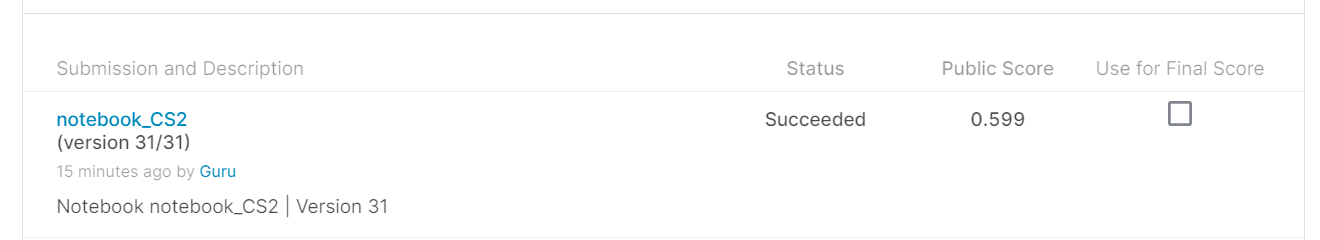